In [1]:
# default_exp collation

# Outage Data Collation

<br>

### Imports

In [2]:
#exports
import json
import numpy as np
import pandas as pd
import geopandas as gpd

from outage import retrieval

import os
import requests
from warnings import warn
from jinja2 import Template

from ipypb import track

In [3]:
import matplotlib.pyplot as plt

from IPython.display import JSON

In [3]:
#exports
def collate_cleaned_incidents_info(dnos=['ukpn', 'ssen', 'wpd', 'sp', 'np', 'enw']):
    cleaned_incidents_info = dict()

    for dno in track(dnos, label='DNOs'):
        raw_dno_incidents_info, cleaned_dno_incidents_info = getattr(retrieval, f'get_{dno}_incidents_info')()
        cleaned_incidents_info[dno] = cleaned_dno_incidents_info
        retrieval.save_json_data(raw_dno_incidents_info, f'{dno}_incidents_info')
        
    return cleaned_incidents_info

In [4]:
cleaned_incidents_info = collate_cleaned_incidents_info()

JSON([cleaned_incidents_info])

           DNOs [█████████████████████████████████████████████] 6/6 [00:24<00:00, 4.06s/it]

   Multiple Ids [█████████████████████████████████████████████] 6/6 [00:01<00:00, 0.24s/it]

        Details [█████████████████████████████████████████████] 68/68 [00:16<00:00, 0.23s/it]

C:\Users\Ayrto\anaconda3\envs\outage\lib\site-packages\urllib3\connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.ssen.co.uk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


 [████████████████████████████████████████████████████████████] 8/8 [00:00<00:00, 0.00s/it]

c:\users\ayrto\desktop\side projects\outage-watch\outage\retrieval.py:237: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 237 of the file c:\users\ayrto\desktop\side projects\outage-watch\outage\retrieval.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = bs(r.text)


<IPython.core.display.JSON object>

In [5]:
#exports
def get_combined_outages_df(cleaned_incidents_info):
    df_outages = pd.DataFrame()

    for dno, dno_outages in cleaned_incidents_info.items():
        df_dno_outages = pd.DataFrame(dno_outages).T.query('incident_active==True')

        df_dno_outages['dno'] = dno
        df_dno_outages = df_dno_outages[['received_time', 'estimated_restored_time', 'postcodes_impacted', 'description', 'dno', 'incident_url']]

        df_dno_outages.index.name = 'incident_id'
        df_dno_outages = df_dno_outages.reset_index()

        df_outages = df_outages.append(df_dno_outages)

    df_outages = df_outages.reset_index(drop=True)
    
    return df_outages

In [6]:
df_outages = get_combined_outages_df(cleaned_incidents_info)
    
df_outages.head(3)

,incident_id,received_time,estimated_restored_time,postcodes_impacted,description,dno,incident_url
0,INCD-230057-Z,2021-04-10T02:52:00,None,"[HA80AD, HA80ED, HA80FD, HA80FE, HA80FH, HA89B...",A fault occurred on an underground electricity...,ukpn,https://www.ukpowernetworks.co.uk/power-cut/ma...
1,INCD-247961-G,2021-04-10T00:20:00,None,[TN74ET],A fault occurred on an underground electricity...,ukpn,https://www.ukpowernetworks.co.uk/power-cut/ma...
2,INCD-54055-V,2021-04-08T09:30:00,None,"[GU14SQ, GU14RY, GU14SG, GU14SJ, GU14SS, GU14YN]",A fault occurred on an underground electricity...,ukpn,https://www.ukpowernetworks.co.uk/power-cut/ma...


<br>

### Locating Post Codes

In [7]:
%%time

df_postcodes = pd.read_csv('../data/postcodes.csv', index_col='postcode')
df_postcodes.index = df_postcodes.index.str.replace(' ', '')

df_postcodes.head()

Wall time: 6 s


,longitude,latitude
postcode,,
AB101AB,-2.096916,57.149606
AB101AF,-2.097806,57.148707
AB101AG,-2.096997,57.149067
AB101AH,-2.094664,57.148080
AB101AL,-2.095909,57.150074


<br>

Although most are, some post-codes aren't included in our database

In [8]:
#exports
check_postcode_is_in_df = lambda postcode, df: postcode in df.index

In [9]:
(check_postcode_is_in_df('W1M1HE', df_postcodes), 
 check_postcode_is_in_df('HP41FD', df_postcodes))

(False, True)

In [10]:
#exports
def get_postcode_location_df(df_postcodes, postcode):
    postcode_is_in_df = check_postcode_is_in_df(postcode, df_postcodes)
    
    if postcode_is_in_df:
        location = df_postcodes.loc[postcode]

        longitude = location['longitude']
        latitude = location['latitude']
        
    else:
        longitude, latitude = None, None

    return longitude, latitude

In [11]:
longitude, latitude = get_postcode_location_df(df_postcodes, 'HP41FD')

longitude, latitude

(-0.5676534391043929, 51.76118688537669)

In [12]:
#exports
get_postcode_url = lambda postcode: f'http://api.getthedata.com/postcode/{postcode}'

In [13]:
postcode = 'W1M1HE'

postcode_url = get_postcode_url(postcode)
r_json = requests.get(postcode_url).json()

JSON(r_json)

<IPython.core.display.JSON object>

In [14]:
#exports
def get_postcode_location_api(postcode):
    longitude, latitude = None, None
    
    postcode_url = get_postcode_url(postcode)
    r_json = requests.get(postcode_url).json()

    if r_json['status'] == 'match':
        data_keys = r_json['data'].keys()
        
        if 'longitude' in data_keys and 'latitude' in data_keys:
            longitude = float(r_json['data']['longitude'])
            latitude = float(r_json['data']['latitude'])

    return longitude, latitude

In [15]:
longitude, latitude = get_postcode_location_api(postcode)

longitude, latitude

(-0.155234, 51.519146)

In [16]:
#exports
class PostCodeLocator:
    def __init__(self, postcodes_fp: str='../data/postcodes.csv'):
        # Loading Post Codes DataFrame
        df_postcodes = pd.read_csv(postcodes_fp, index_col='postcode')
        df_postcodes.index = df_postcodes.index.str.replace(' ', '')
        
        self.df_postcodes = df_postcodes
        
    def get_postcode_location(self, postcode):
        postcode_is_in_df = check_postcode_is_in_df(postcode, self.df_postcodes)

        if postcode_is_in_df:
            longitude, latitude = get_postcode_location_df(self.df_postcodes, postcode)
            
        else:
            longitude, latitude = get_postcode_location_api(postcode)
            
        if longitude is None or latitude is None:
            warn(f'The longitude and latitude of {postcode} could not be determined')
            
        return longitude, latitude

In [17]:
%%time

pcl = PostCodeLocator()

Wall time: 5.92 s


In [18]:
%%time

postcode = 'HP41FD'

pcl.get_postcode_location(postcode)

Wall time: 1.68 s


(-0.5676534391043929, 51.76118688537669)

In [19]:
%%time

postcode = 'W1M1HE'

pcl.get_postcode_location(postcode)

Wall time: 62.3 ms


(-0.155234, 51.519146)

<br>

### Creating Outages Leaflet Map

In [20]:
#exports
def add_outage_longitudes_latitudes(df_outages, postcodes_fp: str='../data/postcodes.csv', null_threshold=1):
    pcl = PostCodeLocator(postcodes_fp)
        
    s_incident_longitudes = pd.Series(index=df_outages.index, dtype='float64')
    s_incident_latitudes = pd.Series(index=df_outages.index, dtype='float64')

    for outage_idx, s_outage in track(df_outages.iterrows(), total=df_outages.shape[0]):
        incident_longitudes = []
        incident_latitudes = []

        for postcode_impacted in s_outage['postcodes_impacted']:
            longitude, latitude = pcl.get_postcode_location(postcode_impacted)

            incident_longitudes += [longitude]
            incident_latitudes += [latitude]

        s_incident_longitudes.loc[outage_idx] = pd.Series(incident_longitudes).mean()
        s_incident_latitudes.loc[outage_idx] = pd.Series(incident_latitudes).mean()
        
    df_outages = (df_outages
                  .assign(longitude=s_incident_longitudes)
                  .assign(latitude=s_incident_latitudes)
                 )
    
    idxs_to_keep = (df_outages.isnull().sum(axis=1)<=null_threshold).replace(False, np.nan).dropna().index
    df_outages = df_outages.loc[idxs_to_keep]
    
    return df_outages

In [21]:
df_outages = add_outage_longitudes_latitudes(df_outages)

df_outages.head(3)

 [████████████████████████████████████████████████████████████] 70/70 [00:14<00:01, 0.20s/it]

C:\Users\Ayrto\anaconda3\envs\outage\lib\site-packages\ipykernel_launcher.py:20: UserWarning: The longitude and latitude of UMS could not be determined
C:\Users\Ayrto\anaconda3\envs\outage\lib\site-packages\ipykernel_launcher.py:20: UserWarning: The longitude and latitude of RH11ONR could not be determined
C:\Users\Ayrto\anaconda3\envs\outage\lib\site-packages\ipykernel_launcher.py:20: UserWarning: The longitude and latitude of TN33 could not be determined
C:\Users\Ayrto\anaconda3\envs\outage\lib\site-packages\ipykernel_launcher.py:20: UserWarning: The longitude and latitude of TN34 could not be determined
C:\Users\Ayrto\anaconda3\envs\outage\lib\site-packages\ipykernel_launcher.py:20: UserWarning: The longitude and latitude of TN386AE could not be determined
C:\Users\Ayrto\anaconda3\envs\outage\lib\site-packages\ipykernel_launcher.py:20: UserWarning: The longitude and latitude of GU4 could not be determined
C:\Users\Ayrto\anaconda3\envs\outage\lib\site-packages\ipykernel_launcher.py:2

,incident_id,received_time,estimated_restored_time,postcodes_impacted,description,dno,incident_url,longitude,latitude
0,INCD-230057-Z,2021-04-10T02:52:00,None,"[HA80AD, HA80ED, HA80FD, HA80FE, HA80FH, HA89B...",A fault occurred on an underground electricity...,ukpn,https://www.ukpowernetworks.co.uk/power-cut/ma...,-0.272263,51.606113
1,INCD-247961-G,2021-04-10T00:20:00,None,[TN74ET],A fault occurred on an underground electricity...,ukpn,https://www.ukpowernetworks.co.uk/power-cut/ma...,0.089125,51.080242
2,INCD-54055-V,2021-04-08T09:30:00,None,"[GU14SQ, GU14RY, GU14SG, GU14SJ, GU14SS, GU14YN]",A fault occurred on an underground electricity...,ukpn,https://www.ukpowernetworks.co.uk/power-cut/ma...,-0.577513,51.237269


In [22]:
#exports
construct_outages_gdf = lambda df_outages: gpd.GeoDataFrame(
    data=df_outages.drop(columns=['longitude', 'latitude']), 
    geometry=gpd.points_from_xy(df_outages['longitude'], df_outages['latitude']),
    crs='EPSG:4326'
)

<AxesSubplot:>

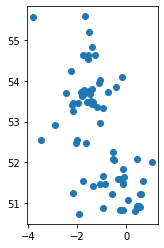

In [23]:
gdf_outages = construct_outages_gdf(df_outages)

gdf_outages.plot()

In [24]:
#exports
def generate_map_js(gdf_outages, js_template_fp='templates/map_js.j2', js_docs_fp='docs/map.js'):
    outages_geojson = json.loads(gdf_outages.to_json(drop_id=True))

    rendered_map_js = Template(open(js_template_fp).read()).render(
        zoom=5,
        center=[53.96, -3.22],
        geojson_features=str(outages_geojson).replace('None', 'null')
    )

    with open(js_docs_fp, 'w', encoding='utf8') as fp:
        fp.write(rendered_map_js)
        
    return

In [25]:
generate_map_js(gdf_outages, '../templates/map_js.j2', '../docs/map.js')

In [26]:
#exports
def clean_outages_df(df_outages):
    df_outages_clean = pd.DataFrame()

    df_outages_clean['Incident'] = df_outages.agg(lambda x: f"<a href=\"{x['incident_url']}\" target=\"_blank\">{x['incident_id']}</a>", axis=1)
    df_outages_clean['Received Time'] = pd.to_datetime(df_outages['received_time']).dt.strftime('%Y-%m-%d %H:%M').fillna('Unknown')
    df_outages_clean['Estimated Restored Time'] = pd.to_datetime(df_outages['estimated_restored_time']).dt.strftime('%Y-%m-%d %H:%M').fillna('Unknown')
    df_outages_clean['Postcodes Impacted'] = df_outages['postcodes_impacted'].str.join(', ')
    df_outages_clean['Operator'] = df_outages['dno'].str.upper()
    df_outages_clean['Description'] = df_outages['description'].str.replace('\n', '<br>')

    df_outages_clean = df_outages_clean.sort_values('Received Time', ascending=False)
    
    return df_outages_clean

In [27]:
df_outages_clean = clean_outages_df(df_outages)

df_outages_clean.head(3)

,Incident,Received Time,Estimated Restored Time,Postcodes Impacted,Operator,Description
15,"<a href=""https://www.ukpowernetworks.co.uk/pow...",2021-04-10 18:09,Unknown,"MK453AQ, MK453JU, MK453LA, MK453LB, MK453LD, M...",UKPN,A fault occurred on a piece of our electrical ...
65,"<a href=""https://www.enwl.co.uk/power-cuts/pow...",2021-04-10 18:06,2021-04-10 22:00,"BB3 2RG, BB3 2RH, BB3 2RJ, BB3 2RL, BB3 2RN, B...",ENW,The power cut in your area has been caused by ...
66,"<a href=""https://www.enwl.co.uk/power-cuts/pow...",2021-04-10 17:57,2021-04-11 00:02,"M18 7DY, M18 7ED, M18 7NF, M18 7NH, M18 7NL, M...",ENW,The power cut in your area has been caused by ...


In [28]:
df_outages_clean.assign(Incident=df_outages['incident_id']).to_csv('../docs/data/outages.csv', index=False)

In [41]:
#exports
def generate_index_md(df_outages_clean, md_template_fp='templates/index_md.j2', docs_md_fp='docs/index.md'):
    rendered_index_md = Template(open(md_template_fp).read()).render(
        map_width='600px',
        map_height='500px',
        md_table=df_outages_clean.to_markdown(index=False)
    )

    with open(docs_md_fp, 'w', encoding='utf8') as fp:
        fp.write(rendered_index_md)
        
    return

In [42]:
generate_index_md(df_outages_clean, md_template_fp='../templates/index_md.j2', docs_md_fp='../docs/index.md')

In [5]:
#hide
from nbdev.export import *
notebook2script()

Converted 01-retrieval.ipynb.
Converted 02-collation.ipynb.
Converted 03-deployment.ipynb.
